In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import joblib


2024-11-18 05:05:48.718147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 05:05:48.835115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 05:05:48.864794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 05:05:49.063988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
processed_data = pd.read_csv('./processed_data.csv')
processed_data.head() # Reimportamos la información para no redundar con el preprocesamiento

,processed_abstract,entity_1_type,entity_2_type,relationship_label
0,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
1,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
2,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
3,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
4,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27


In [3]:

# Load the LabelEncoder from the file
label_encoder = joblib.load('./label_encoder.pkl')


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

def tokenize_data(examples):
    return tokenizer(examples['processed_abstract'], padding="max_length", truncation=True)

# Apply tokenization to the whole dataset
# tokenized_data = processed_data.apply(lambda row: tokenize_data(row), axis=1)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
X = processed_data['processed_abstract']
y = processed_data['relationship_label']

# Step 1: Split into training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Step 2: Split the temporary set (30%) into validation (66% of 30%) and test (33% of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# Check the distribution
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 15670
Validation set size: 4477
Test set size: 2239


In [6]:
# Define max sequence length for BERT input
maxlen = 200

# Tokenize training data
train_encodings = tokenizer(
    X_train.tolist(), # Convert to list for batch tokenization
    truncation=True,
    padding="max_length",
    max_length=maxlen
)

# Tokenize testing data
test_encodings = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding="max_length",
    max_length=maxlen
)

In [7]:
class RelationshipDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert to torch Dataset objects
train_dataset = RelationshipDataset(train_encodings, y_train.tolist())
test_dataset = RelationshipDataset(test_encodings, y_val.tolist())


In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [9]:
torch.cuda.is_available()

True

In [10]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example of creating a tensor on the GPU
tensor = torch.tensor([1.0, 2.0, 3.0], device=device)

# Move your model to the GPU
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
# Freeze first model layers
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# Set up training arguments
# Modificar los argumentos de entrenamiento para incluir acumulación de gradientes
training_args = TrainingArguments(
    output_dir='./results',               # Directorio de salida para checkpoints
    eval_strategy='epoch',          # Evaluar al final de cada epoch
    per_device_train_batch_size=8,        # Tamaño de batch para entrenamiento
    per_device_eval_batch_size=8,         # Tamaño de batch para evaluación
    gradient_accumulation_steps=4,        # Acumulación de gradientes cada 4 pasos
    num_train_epochs=10,                  # Total de épocas (con early stopping)
    learning_rate=2e-5,                   # Tasa de aprendizaje
    logging_dir='./logs',                 # Directorio de logs
    save_strategy='epoch',                # Guardar al final de cada epoch
    load_best_model_at_end=True,          # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model='eval_loss',    # Métrica de referencia para el mejor modelo
    greater_is_better=False,              # Indicar que menor pérdida es mejor
    save_total_limit=2,                    # Limitar el número de checkpoints guardados
    report_to=[],  
)

# Initialize Trainer with model, arguments, dataset, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,1.967538,0.430422,0.359446,0.406939,0.430422
1,2.545500,1.397178,0.612464,0.557019,0.560868,0.612464
2,1.705900,1.106759,0.679473,0.638658,0.639254,0.679473
4,1.027400,0.876449,0.734420,0.715762,0.713965,0.734420
5,0.884500,0.828146,0.750726,0.736184,0.743845,0.750726
6,0.792100,0.788406,0.757427,0.743834,0.746198,0.757427
8,0.662000,0.728342,0.778646,0.769086,0.769748,0.778646
9,0.626000,0.723703,0.778870,0.768804,0.768848,0.778870


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

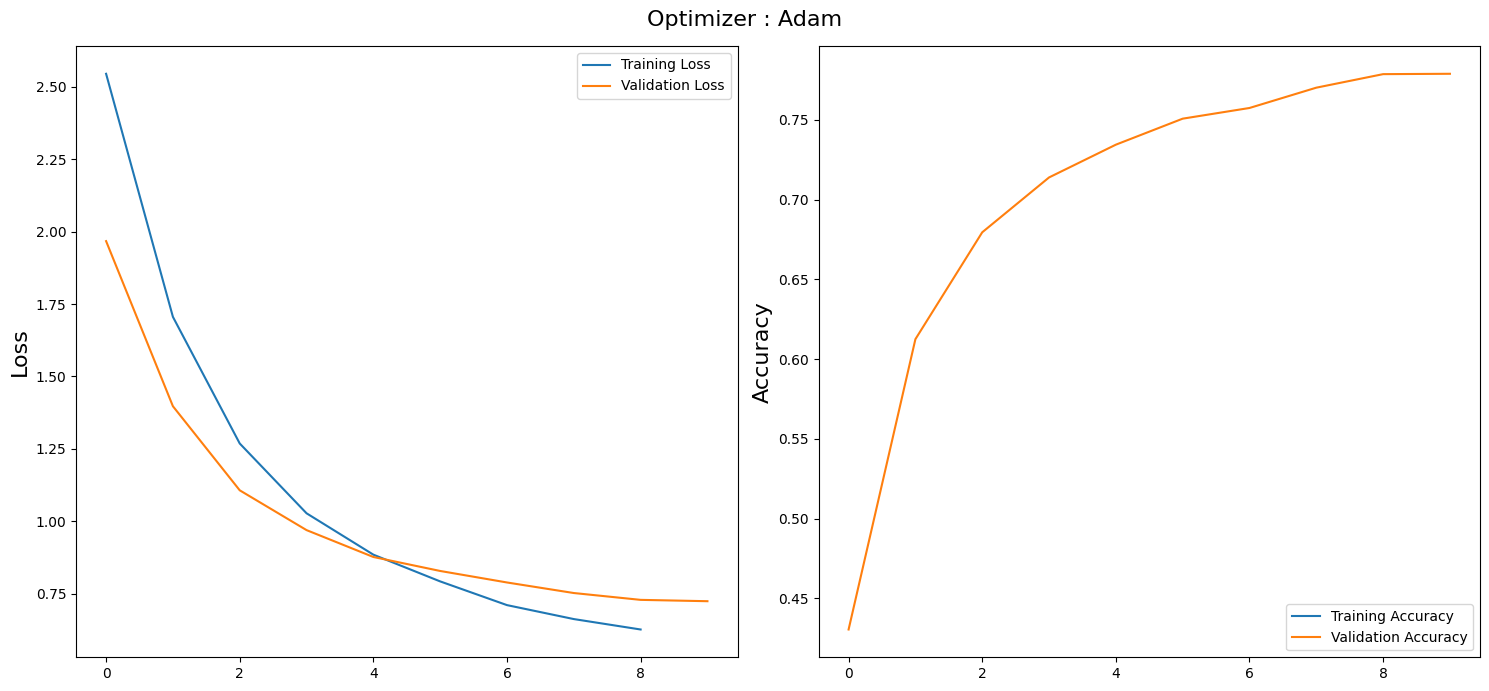

In [12]:
from transformers import TrainerCallback  # Importar TrainerCallback
import matplotlib.pyplot as plt

# Almacenar las métricas durante el entrenamiento
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Custom Callback para almacenar las métricas
class MetricsLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Pérdida de entrenamiento y validación
            if 'loss' in logs:
                train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                val_losses.append(logs['eval_loss'])
            
            # Precisión de entrenamiento y validación
            if 'accuracy' in logs:
                train_accuracies.append(logs['accuracy'])
            if 'eval_accuracy' in logs:
                val_accuracies.append(logs['eval_accuracy'])

# Añadir el callback al entrenador
trainer.add_callback(MetricsLoggerCallback)

# Entrenar el modelo
trainer.train()

# Crear la figura
plt.figure(figsize=(15, 7))

# Subgráfica para la pérdida
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')

# Subgráfica para la precisión
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


In [13]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.7237028479576111, 'eval_accuracy': 0.7788697788697788, 'eval_f1': 0.7688038219914535, 'eval_precision': 0.768848074719879, 'eval_recall': 0.7788697788697788, 'eval_runtime': 45.8527, 'eval_samples_per_second': 97.639, 'eval_steps_per_second': 12.213, 'epoch': 9.98468606431853}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


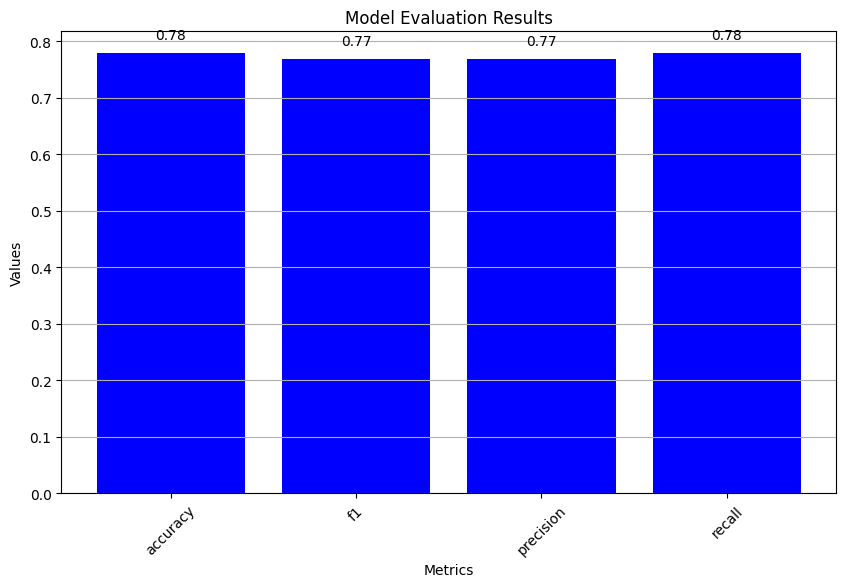

In [14]:
# Extract metrics
metrics = ['accuracy','f1','precision','recall']
values = [eval_results[f"eval_{metric}"] for metric in metrics]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='blue')
plt.title('Model Evaluation Results')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add value labels above each bar
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate for the label
        bar.get_height() + 0.02,            # Y-coordinate, a bit above the bar
        f"{value:.2f}",                     # Value label, rounded to 2 decimals
        ha='center', va='bottom'            # Center alignment
    )

# Show plot
plt.show()

In [15]:
model.save_pretrained('./relationship_model')
tokenizer.save_pretrained('./relationship_model')
pd.to_pickle(label_encoder, './relationship_model/label_encoder.pkl')

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

In [18]:
%pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
Note: you may need to restart the kernel to use updated packages.


In [19]:
from datasets import Dataset

# Convert the Series to a Dataset
train_dataset = Dataset.from_pandas(X_train.to_frame(name="text"))
val_dataset = Dataset.from_pandas(X_val.to_frame(name="text"))
test_dataset = Dataset.from_pandas(X_test.to_frame(name="text"))

In [31]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("relationship_model")  # Replace with your model's name

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [37]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/15670 [00:00<?, ? examples/s]

Map:   0%|          | 0/4477 [00:00<?, ? examples/s]

Map:   0%|          | 0/2239 [00:00<?, ? examples/s]

In [21]:
# Get predictions on the training set
train_preds = trainer.predict(tokenized_train_dataset)

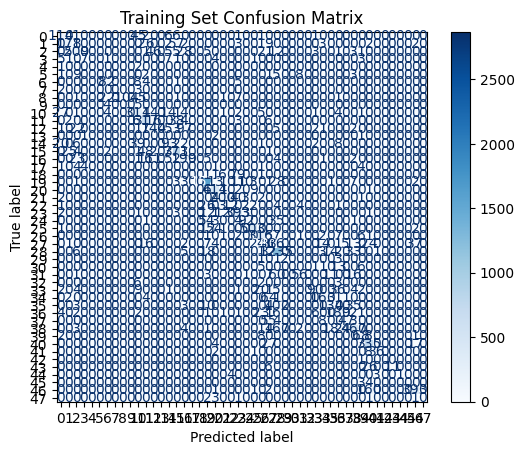

In [22]:
y_train_pred = np.argmax(train_preds.predictions, axis=1)

# Plot confusion matrix for the training set
plot_confusion_matrix(y_train, y_train_pred, title="Training Set Confusion Matrix")

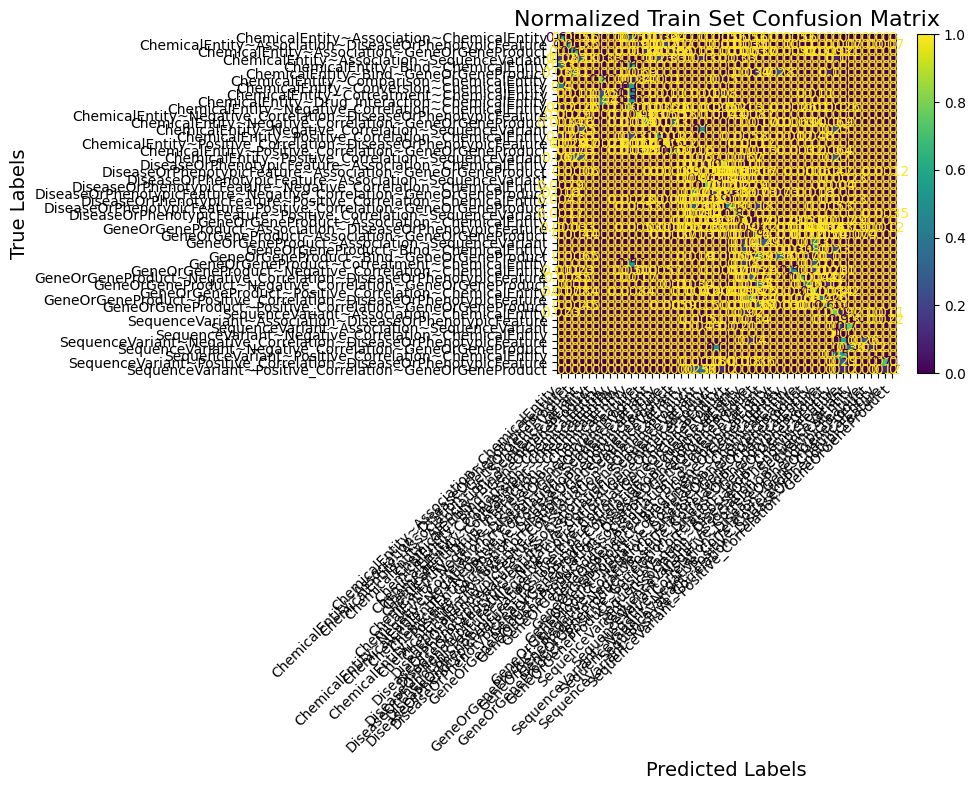

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
class_names = label_encoder.classes_

# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    display_labels=class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='true'  # Normalize the matrix to show proportions
)
plt.title("Normalized Train Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

In [38]:
# Get predictions on the training set
train_preds = trainer.predict(tokenized_train_dataset)
train_preds

PredictionOutput(predictions=array([[ 6.2864537 ,  0.41685054,  0.9433032 , ...,  0.7918986 ,
        -1.7531099 ,  0.11861701],
       [ 1.5270896 ,  0.04235063,  4.584768  , ..., -1.2320215 ,
        -2.6363873 , -1.0992048 ],
       [-3.1324813 ,  1.1511077 , -2.5536466 , ..., -0.04279418,
         5.77964   ,  0.19392727],
       ...,
       [-3.0579724 ,  0.9028359 , -1.9034218 , ...,  0.13257076,
         6.408763  ,  0.5027626 ],
       [ 4.5736938 ,  2.076666  ,  2.911303  , ...,  0.49652648,
        -1.2731464 , -0.37529874],
       [ 0.5965903 ,  0.45565194,  1.572977  , ..., -0.44483244,
        -1.7454818 , -0.25164902]], dtype=float32), label_ids=None, metrics={'test_runtime': 456.0321, 'test_samples_per_second': 34.362, 'test_steps_per_second': 4.296})

In [40]:
# Convert the predictions to indices
y_train_pred = np.argmax(train_preds.predictions, axis=1)
y_train_pred

array([ 0, 12, 40, ..., 40, 14, 33])

In [43]:
y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)
y_train_true_decoded = label_encoder.inverse_transform(y_train)

In [45]:
# Step 2: Extract only the relationship part from the format 'entity1~relationship~entity2'
def extract_relationship_from_encoded_string(encoded_string):
    # Split the string and return the second part (relationship)
    return encoded_string.split('~')[1]

In [46]:
# Apply the extraction to both predicted and true labels
y_train_pred_relationships = [extract_relationship_from_encoded_string(label) for label in y_train_pred_decoded]
y_train_true_relationships = [extract_relationship_from_encoded_string(label) for label in y_train_true_decoded]


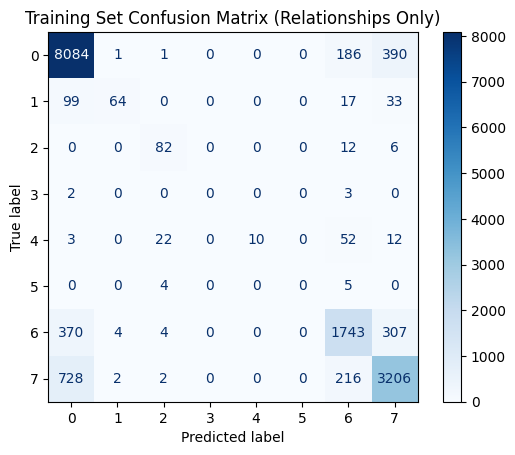

In [47]:
# Step 3: Plot the confusion matrix with these simplified labels
plot_confusion_matrix(y_train_true_relationships, y_train_pred_relationships, title="Training Set Confusion Matrix (Relationships Only)")

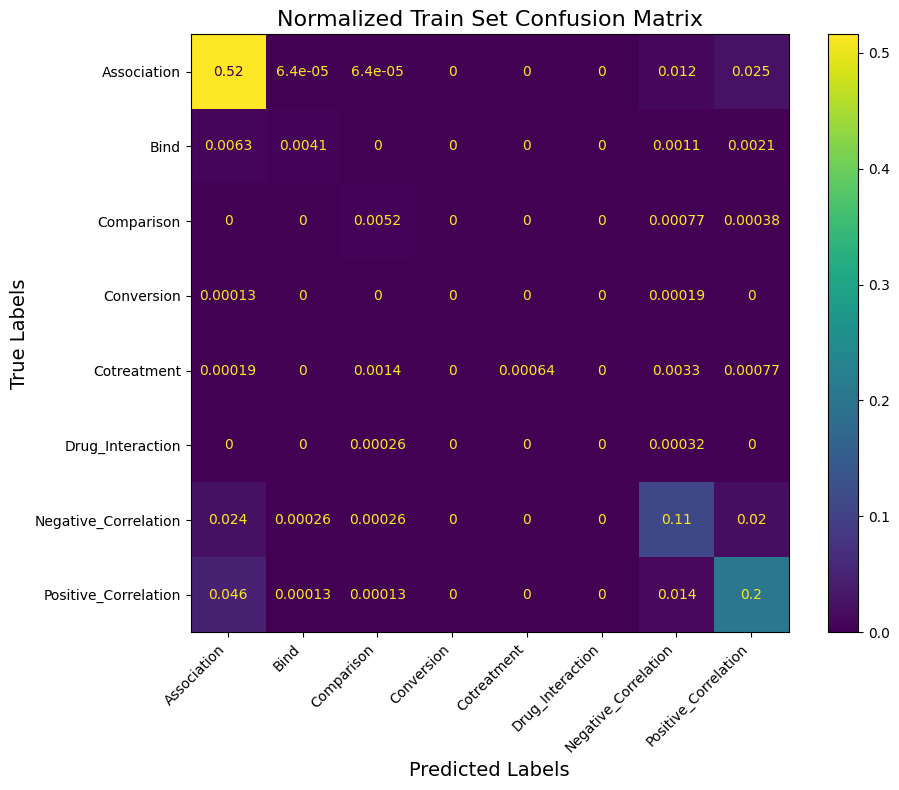

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
# Apply the extraction function to all class names
relationship_class_names = [extract_relationship_from_encoded_string(label) for label in class_names]
relationship_class_names = sorted(set(relationship_class_names))
# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_train_true_relationships,
    y_train_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='true'  # Normalize the matrix to show proportions
)
plt.title("Normalized Train Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

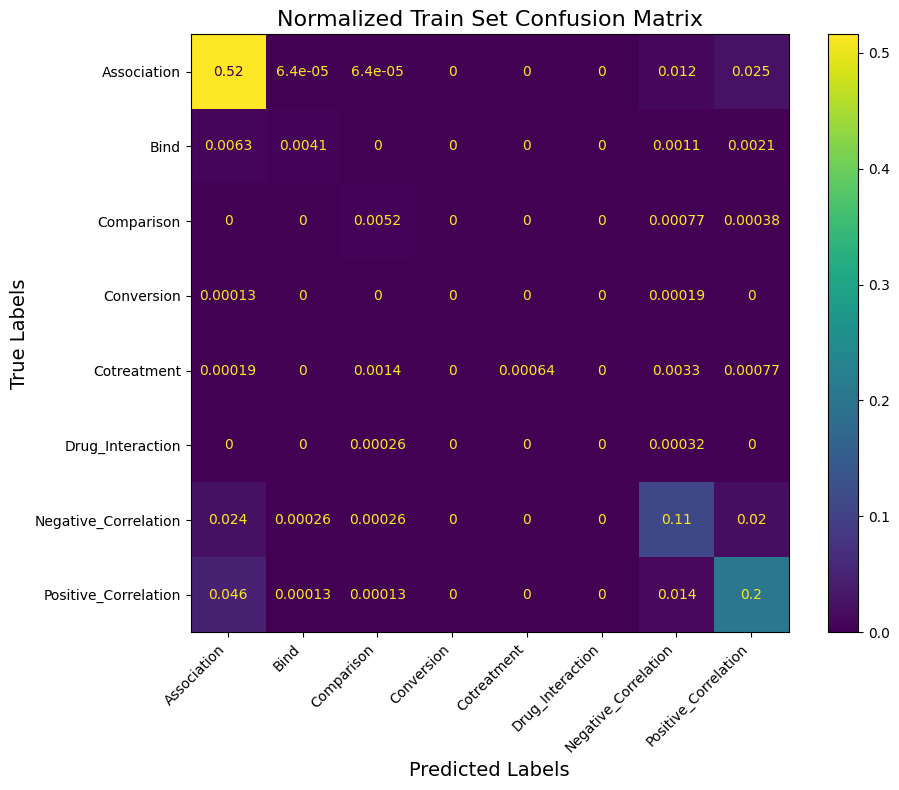

In [51]:
# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_train_true_relationships,
    y_train_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='all'  # Normalize the matrix to show proportions
)
plt.title("Normalized Train Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

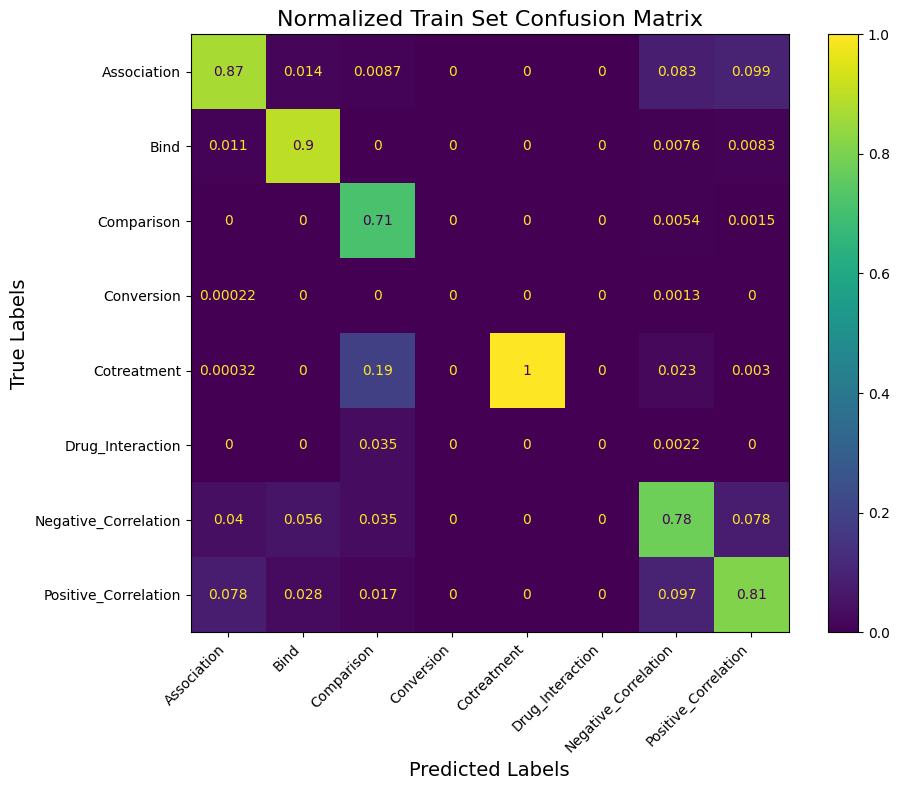

In [53]:
# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_train_true_relationships,
    y_train_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='pred'  # Normalize the matrix to show proportions
)
plt.title("Normalized Train Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

In [54]:
# Get predictions on the validation set
val_preds = trainer.predict(tokenized_val_dataset)

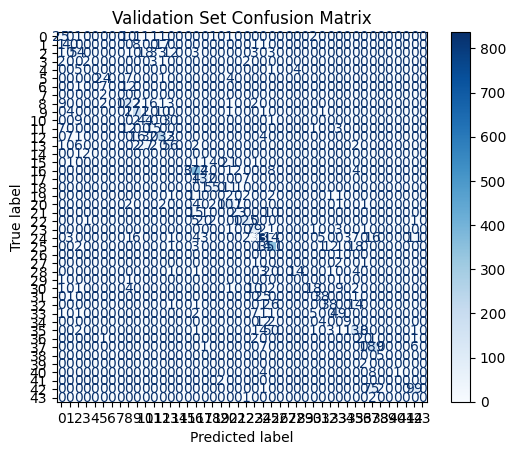

In [55]:
y_val_pred = np.argmax(val_preds.predictions, axis=1)

# Plot confusion matrix for the validation set
plot_confusion_matrix(y_val, y_val_pred, title="Validation Set Confusion Matrix")

ValueError: The number of FixedLocator locations (44), usually from a call to set_ticks, does not match the number of labels (48).

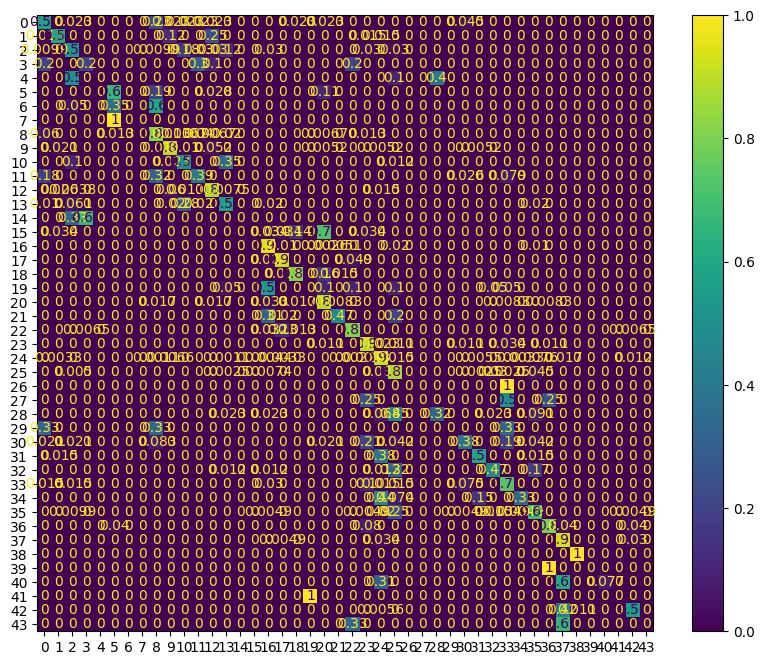

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
class_names = label_encoder.classes_

# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_val_pred,
    display_labels=class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='true'  # Normalize the matrix to show proportions
)
plt.title("Normalized Validation Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

In [57]:
y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
y_val_true_decoded = label_encoder.inverse_transform(y_val)

In [58]:
# Apply the extraction to both predicted and true labels
y_val_pred_relationships = [extract_relationship_from_encoded_string(label) for label in y_val_pred_decoded]
y_val_true_relationships = [extract_relationship_from_encoded_string(label) for label in y_val_true_decoded]


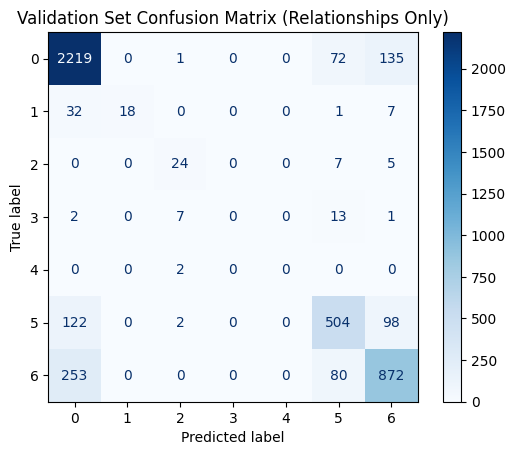

In [59]:
# Step 3: Plot the confusion matrix with these simplified labels
plot_confusion_matrix(y_val_true_relationships, y_val_pred_relationships, title="Validation Set Confusion Matrix (Relationships Only)")

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (8).

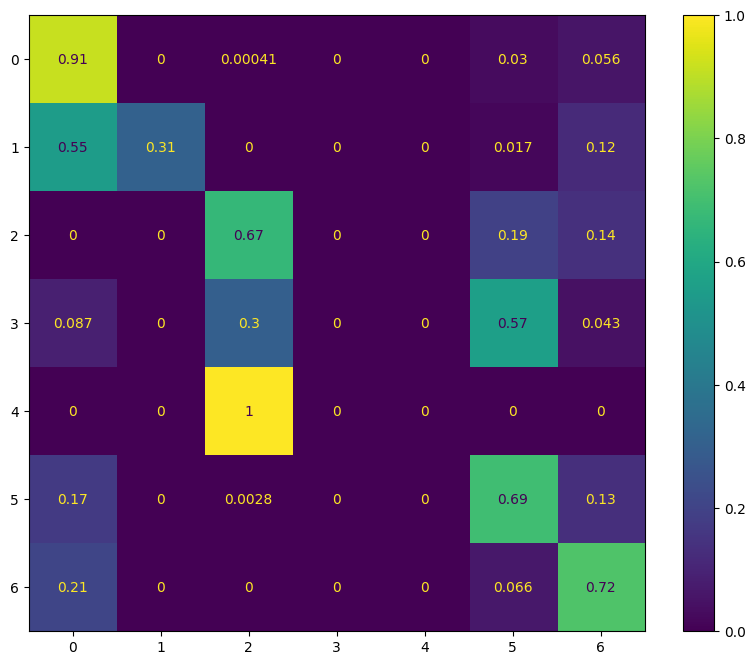

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
# Apply the extraction function to all class names
relationship_class_names = [extract_relationship_from_encoded_string(label) for label in class_names]
relationship_class_names = sorted(set(relationship_class_names))
# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_val_true_relationships,
    y_val_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='true'  # Normalize the matrix to show proportions
)
plt.title("Normalized Validation Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (8).

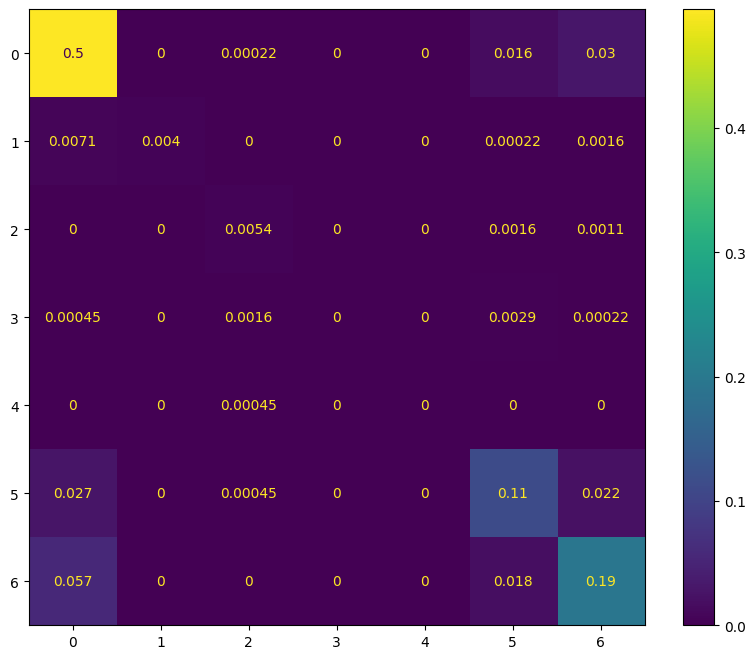

In [62]:
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_val_true_relationships,
    y_val_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='all'  # Normalize the matrix to show proportions
)
plt.title("Normalized Validation Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (8).

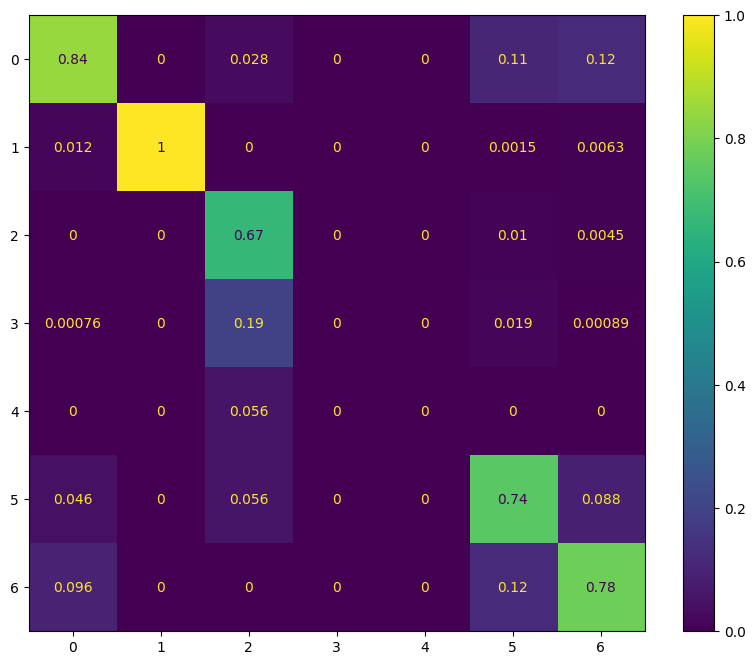

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_val_true_relationships,
    y_val_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='pred'  # Normalize the matrix to show proportions
)
plt.title("Normalized Validation Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

In [64]:
# Get predictions on the test set
test_preds = trainer.predict(tokenized_test_dataset)

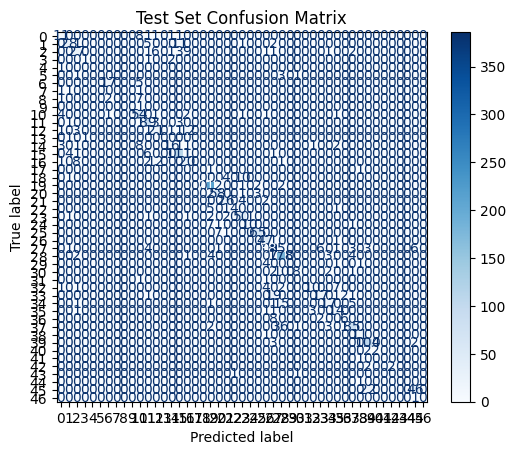

In [65]:
y_test_pred = np.argmax(test_preds.predictions, axis=1)

# Plot confusion matrix for the test set
plot_confusion_matrix(y_test, y_test_pred, title="Test Set Confusion Matrix")

ValueError: The number of FixedLocator locations (47), usually from a call to set_ticks, does not match the number of labels (48).

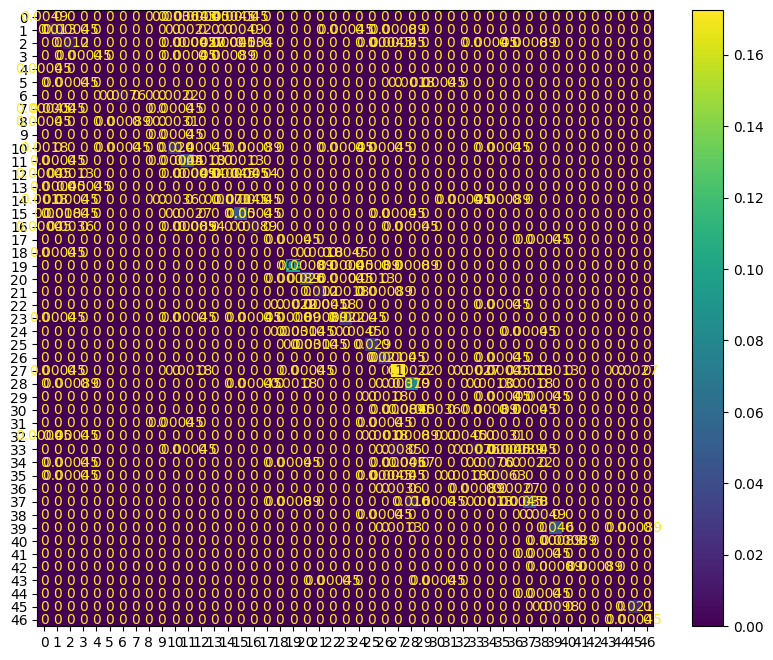

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
class_names = label_encoder.classes_

# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='all'  # Normalize the matrix to show proportions
)
plt.title("Normalized Test Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

In [67]:
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
y_test_true_decoded = label_encoder.inverse_transform(y_test)
# Apply the extraction to both predicted and true labels
y_test_pred_relationships = [extract_relationship_from_encoded_string(label) for label in y_test_pred_decoded]
y_test_true_relationships = [extract_relationship_from_encoded_string(label) for label in y_test_true_decoded]


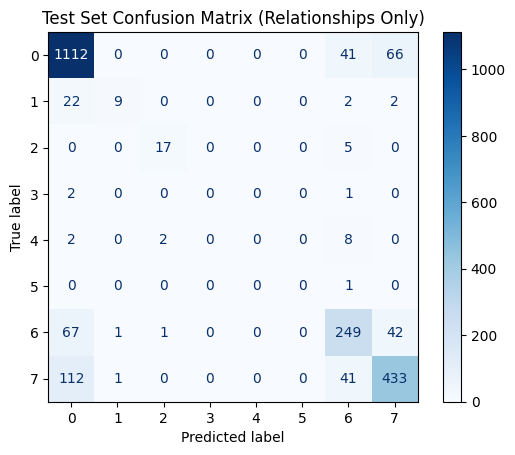

In [69]:
# Step 3: Plot the confusion matrix with these simplified labels
plot_confusion_matrix(y_test_true_relationships, y_test_pred_relationships, title="Test Set Confusion Matrix (Relationships Only)")

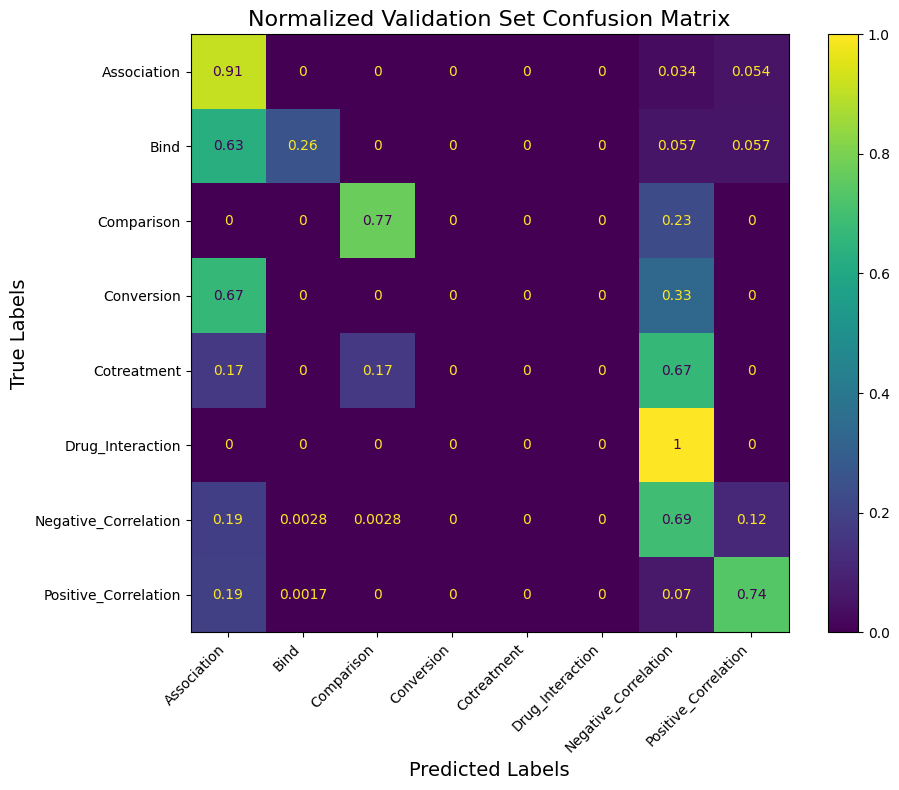

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
# Apply the extraction function to all class names
relationship_class_names = [extract_relationship_from_encoded_string(label) for label in class_names]
relationship_class_names = sorted(set(relationship_class_names))
# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_test_true_relationships,
    y_test_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='true'  # Normalize the matrix to show proportions
)
plt.title("Normalized Validation Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

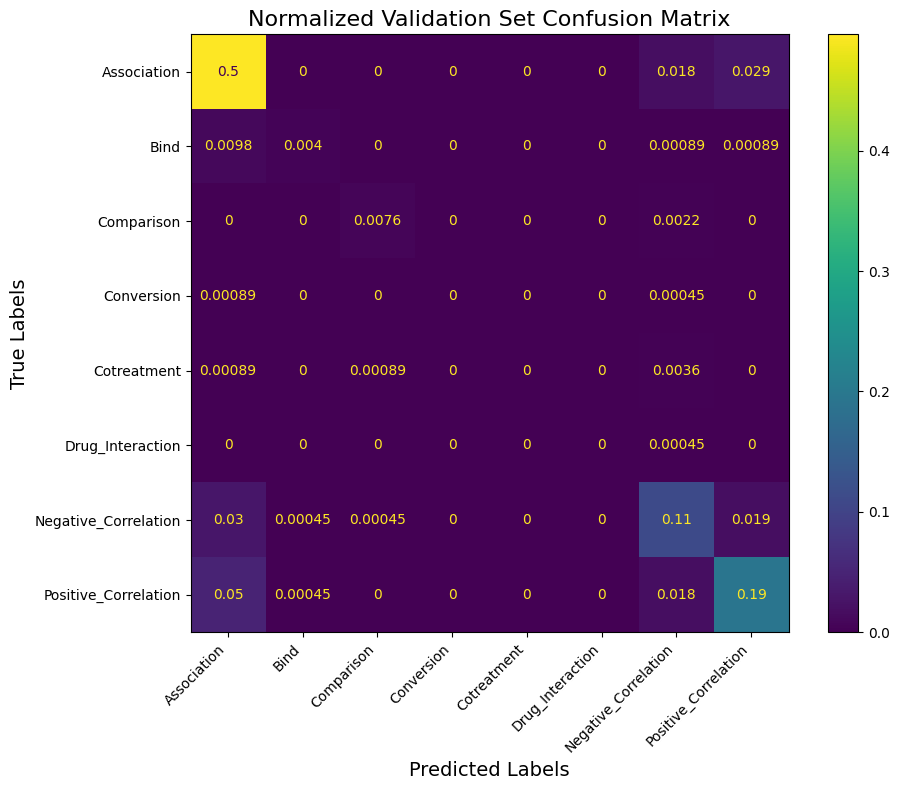

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
# Apply the extraction function to all class names
relationship_class_names = [extract_relationship_from_encoded_string(label) for label in class_names]
relationship_class_names = sorted(set(relationship_class_names))
# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_test_true_relationships,
    y_test_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='all'  # Normalize the matrix to show proportions
)
plt.title("Normalized Validation Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

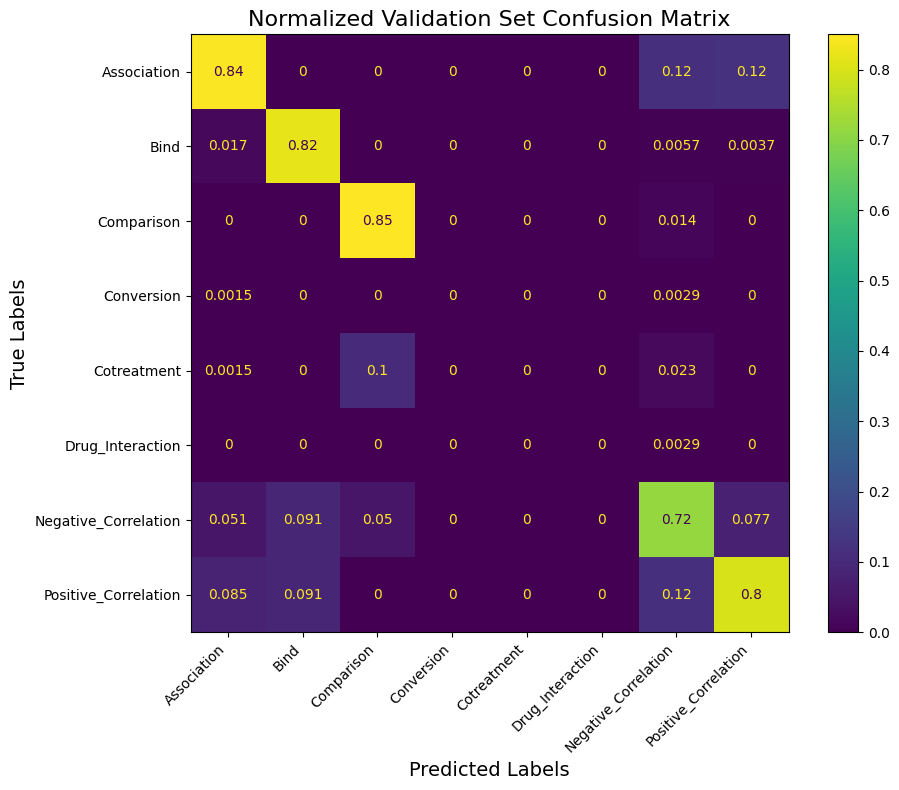

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming `label_encoder` is your LabelEncoder instance used for encoding
# Get class names
# Apply the extraction function to all class names
relationship_class_names = [extract_relationship_from_encoded_string(label) for label in class_names]
relationship_class_names = sorted(set(relationship_class_names))
# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better readability
ConfusionMatrixDisplay.from_predictions(
    y_test_true_relationships,
    y_test_pred_relationships,
    display_labels=relationship_class_names,
    cmap='viridis',  # Use a colormap with better contrast
    ax=ax,
    colorbar=True,  # Include a color bar for more context
    normalize='pred'  # Normalize the matrix to show proportions
)
plt.title("Normalized Validation Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for clear display
plt.show()

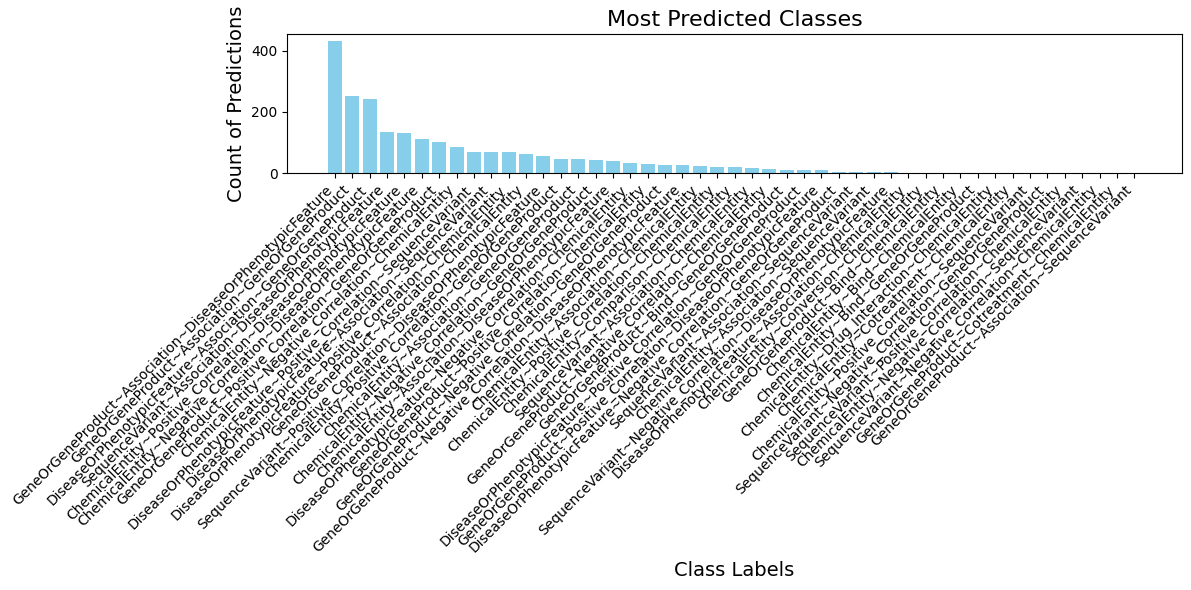

In [75]:
# Bar graph of the most predicted classes
# Count occurrences of each class in the predictions
class_counts = np.bincount(y_test_pred)

# Get the sorted indices (class labels) based on counts in descending order
most_predicted_order = np.argsort(class_counts)[::-1]

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar([class_names[i] for i in most_predicted_order], class_counts[most_predicted_order], color='skyblue')
plt.title("Most Predicted Classes", fontsize=16)
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Count of Predictions", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


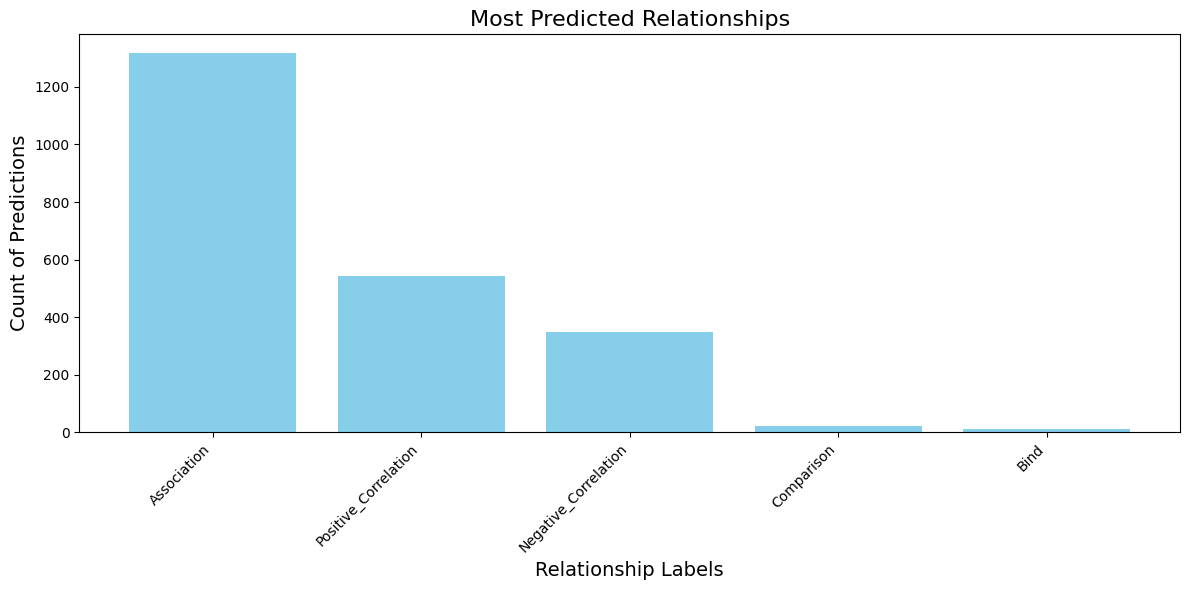

In [78]:
# Step 1: Decode predicted labels back to their original format
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

# Step 2: Extract only the relationship part from each decoded label
y_test_pred_relationships = [extract_relationship_from_encoded_string(label) for label in y_test_pred_decoded]

# Step 3: Count occurrences of each relationship in the predictions
unique, counts = np.unique(y_test_pred_relationships, return_counts=True)

# Sort the relationships by count in descending order
sorted_indices = np.argsort(counts)[::-1]
sorted_relationships = [unique[i] for i in sorted_indices]
sorted_counts = counts[sorted_indices]

# Step 4: Plot the bar graph of the most predicted relationships
plt.figure(figsize=(12, 6))
plt.bar(sorted_relationships, sorted_counts, color='skyblue')
plt.title("Most Predicted Relationships", fontsize=16)
plt.xlabel("Relationship Labels", fontsize=14)
plt.ylabel("Count of Predictions", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
